In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.data.auto_mturk import (create_mturk_client,clean_own_worker,
                                 Turker,MTurkparam,get_batch_indexes)
from src.data.watcher import Watcher

from src.visualization.turk_widgets import get_control_panel
from src.data.auto_drive import get_drive_service, download_drive_txt, download_all_csv_results,download_drive_spreadsheet
from src.data.fraudulous import detect_repeat_frauders,detect_honey_frauders
from src.data.preprocess import get_batch_indexes
from src.utils import generate_password 
from src.constants import (WATCHER_PATH,NMB_FORMS_THRESHOLD,TOKEN_PATH,
                           CREDS_PATH, URL_INDEX_PATH, AWS_KEYS_PATH,
                           FORMS_RESULTS_DIR,WATCHER_FORMS_RESULTS_DIR,HONEYPOTS)
from src.utils import read_access_keys
import subprocess
import pandas as pd
import jdc
from IPython.display import clear_output
import pickle as pk
from src.constants import HONEYPOTS
import Levenshtein
import pickle as pk
from pathlib import Path

import ipywidgets as widgets
from src.utils import get_batch_form_urls,create_batch_directories
from pdb import set_trace

## Urls info retrieval

<div class="alert alert-success">
Adapt the following variables if you want a specific batch size/ batch number. If BATCH_NUMBER is set to <b>None</b>, the batch number is automatically computed. 
</div>

In [3]:
create_batch_directories(FORMS_RESULTS_DIR,20)

In [144]:
BATCH_SIZE = 7
MAX_ASSIGNMENTS = 30
BATCH_NUMBER = None

In [145]:
# retrieve the indexes for the next batch to compute
batch_dir,batch_number,form_indexes = get_batch_indexes(parent_dir=FORMS_RESULTS_DIR,
                                              batch_number=None,
                                              batch_size=BATCH_SIZE,
                                              MaxAssignments=MAX_ASSIGNMENTS)
print(f"Treating batch number {batch_number},forms:{form_indexes}")

All batches clean up to batch 18
Treating batch number 19,forms:[133, 134, 135, 136, 137, 138, 139]


In [146]:
file_id = "1o_7rRLn48ZRHlo0x_8gNILbae_4q-DbB1WneuKaRFI0"
# Retrieve the urls of the forms generated by the app script
service = get_drive_service()
formidx2url,formidx2gid = get_batch_form_urls(service,file_id,form_indexes)

download_all_csv_results(formidx2gid,batch_dir,service)

formidx2url

Download 100%


{}

## MTurk management

In [134]:
param = MTurkparam(MaxAssignments = MAX_ASSIGNMENTS,
             LifetimeInDays = 4,       #
             AutoApprovalDelayInDays=1, # time after submission before autoapproval
             AssignmentDurationInSeconds=1000,  # max time to perform the assignment
             Reward='0.3',
             n_forms=len(formidx2gid),
             max_forms_per_worker=50,
             production=True)

Estimated cost:63.00 $


In [135]:
turk = Turker(param=param,
              gservice=service,
              formidx2url=formidx2url,
              formidx2gid=formidx2gid,
              formrespath=batch_dir)

Loading hit2form


In [138]:
get_control_panel(turk,file_id)

Text(value='', placeholder='Results HITid/formidx')

In [139]:
turk.save_worker_infos()

Saved worker infos at /dlabdata1/emojis/forms_results/18


In [140]:
download_all_csv_results(formidx2gid,batch_dir,service)

In [113]:
new_balance = float(turk.client.get_account_balance()['AvailableBalance'])
print(f"Cost of last batch: {balance - new_balance}")
balance = new_balance

Cost of last batch: 88.19999999999891


In [17]:
balance = new_balance

# Debug

In [68]:
form2hit = {val:key for key,val in turk.hit2form.items()}

In [69]:
hit_id = form2hit[13]

In [70]:
d = turk.client.list_assignments_for_hit(HITId=hit_id,MaxResults=100)

In [72]:
wids = [ass['WorkerId'] for ass in d['Assignments']]

In [42]:
turk.p.url

'https://workersandbox.mturk.com/mturk'

## Cleaning workers 

In [39]:
formidx2url_watcher

{0: 'https://forms.gle/hx86sRdViuoq8nBKA',
 1: 'https://forms.gle/69zS696fwiBAK9oH8',
 2: 'https://forms.gle/g6WgbMc8sKF1rhff9',
 3: 'https://forms.gle/CPD69uKDCubRSAPJ8',
 4: 'https://forms.gle/pKbi4YqNvrzkycJe6',
 5: 'https://forms.gle/8pqgRFcRwcVkitUR6',
 6: 'https://forms.gle/uEA94Nf8gsD3KGbZA',
 7: 'https://forms.gle/g69B5cEvM45Mp1TF9',
 8: 'https://forms.gle/sgSGMBpkV6esnqLj9',
 9: 'https://forms.gle/2WFo57YiUZEbcKLYA',
 10: 'https://forms.gle/FqfwJT2LdVZETvRt7',
 11: 'https://forms.gle/cqTsm7uEyvw8F9Ju7',
 12: 'https://forms.gle/NQQtdwZfTud6K7Wj7',
 13: 'https://forms.gle/R4joTwivPBXArc48A',
 14: 'https://forms.gle/eRN6KN41nDdvnphr8',
 15: 'https://forms.gle/QYNujAb69YTtxbkg8',
 16: 'https://forms.gle/WU487nvHiDhN52Te8',
 17: 'https://forms.gle/sYoMyv9VrHirLDvZ7',
 18: 'https://forms.gle/nq5ee6VhzQmoPHtH7',
 19: 'https://forms.gle/mV2ySFKxXDM5fvam7',
 20: 'https://forms.gle/LoGR5x2BVKZbuATf8',
 21: 'https://forms.gle/zYLd5nWugFdWqQZa6',
 22: 'https://forms.gle/ctFBmxvKQfEMYifs6'

In [85]:
from src.utils import get_form_urls
from src.constants import WATCHER_FORMS_RESULTS_DIR
_,formidx2gid_watcher = get_form_urls(service,file_id)
monitor = Watcher(form_results_dir=WATCHER_FORMS_RESULTS_DIR,
                  formidx2gid=formidx2gid_watcher,
                  drive_service=service,
                  max_forms=50,
                  production=True)


Download 100%


In [141]:
workers = monitor.get_workers_count()

In [142]:
workers

A1DD23J1WBGQUU    56
A13OMD8QDV0YON    54
A1I72NHC21347A    54
A2C7A6E70NYNUI    52
A2D2JX8R0QU9G4    52
                  ..
A31UXXZVI3U4E2     1
AMW5JN5PYY3AX      1
ADV7NMTM6D2OF      1
ALML8V38FDV0       1
A3EYRDEQ7CXUMN     1
Name: Worker ID, Length: 468, dtype: int64

<AxesSubplot:>

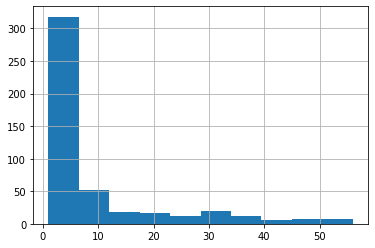

In [143]:
workers.hist()

In [53]:
monitor.get_tagged_workers("3N5C8MI2ZCLZ0AAT5UVXEVWWHP8G22")

set()

In [38]:
monitor.clean_all_workers("3N5C8MI2ZCLZ0AAT5UVXEVWWHP8G22")

Download 100%
All workers cleaned! (set())


In [24]:
a = turk.client.list_reviewable_hits()['HITs']

In [30]:
turk.hit2form

{'3WUVMVA7OBOVA6EUHPVJTAA5SA2ZAZ': 0, '3HYV4299H0HJGNUJO4XSC93SEGU8EZ': 1}

In [71]:
exworkers = set()
qualifs = turk.client.list_workers_with_qualification_type(QualificationTypeId="3OR1BBO28PIVPWZMRDTWE8U6OZXNGN")
for qualif in qualifs['Qualifications']:
    if qualif['QualificationTypeId'] == "3OR1BBO28PIVPWZMRDTWE8U6OZXNGN":
        exworkers.add(qualif['WorkerId'])

RequestError: An error occurred (RequestError) when calling the ListWorkersWithQualificationType operation: QualificationType 3OR1BBO28PIVPWZMRDTWE8U6OZXNGN does not exist. (1606845848334)

https://workersandbox.mturk.com/mturk/

In [33]:
clean_own_worker(turk.client,"3OR1BBO28PIVPWZMRDTWE8U6OZXNGN")

Worker already clean


## Qualifications

In [12]:
# Create the qualification we need to distinguish workers who already performed an emoji task
turk.client.create_qualification_type(
    Name='emojidone',
    Description="Qualification to recognize workers that already performed an emoji-related task",
    QualificationTypeStatus='Active',
    AutoGranted=True,
    AutoGrantedValue=0
)
# production 3N5C8MI2ZCLZ0AAT5UVXEVWWHP8G22
# sandbox 3OR1BBO28PIVPWZMRDTWE8U6OZXNGN

{'QualificationType': {'QualificationTypeId': '3N5C8MI2ZCLZ0AAT5UVXEVWWHP8G22',
  'CreationTime': datetime.datetime(2020, 12, 1, 10, 35, 46, tzinfo=tzlocal()),
  'Name': 'emojidone',
  'Description': 'Qualification to recognize workers that already performed an emoji-related task',
  'QualificationTypeStatus': 'Active',
  'IsRequestable': True,
  'AutoGranted': True,
  'AutoGrantedValue': 0},
 'ResponseMetadata': {'RequestId': 'e7843690-3baf-4459-8b16-a9ee51eaf8ec',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e7843690-3baf-4459-8b16-a9ee51eaf8ec',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '318',
   'date': 'Tue, 01 Dec 2020 09:35:45 GMT'},
  'RetryAttempts': 0}}

In [11]:
turk.client.get_qualification_type(QualificationTypeId='3OR1BBO28PIVPWZMRDTWE8U6OZXNGN')

RequestError: An error occurred (RequestError) when calling the GetQualificationType operation: QualificationType 3OR1BBO28PIVPWZMRDTWE8U6OZXNGN does not exist. (1606815318089)

In [ ]:
turker.client.update_qualification_type(
    QualificationTypeId='3OR1BBO28PIVPWZMRDTWE8U6OZXNGN',
    QualificationTypeStatus='Active',
    Test='string',
    AnswerKey='string',
    TestDurationInSeconds=123,
    RetryDelayInSeconds=123,
    AutoGranted=False,
    AutoGrantedValue=123
)